In [2]:
from soundmatrix.processing import extraction, machine_learning
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from python_speech_features import mfcc
from pydub import AudioSegment
import os

In [5]:
npzf = np.load('./samples/chunks_signal/0_Sonus_naturalis_021DD29C.npz')

In [6]:
npzf['a']

array([  46., -286., -341., ...,  127., -649., -825.])

## Resampling
Resampling to 22050Hz frequency

In [ ]:
processing.resample_dir('./mp3', './resampled', sr=22050, channels=1)

## Signal/noise split

In [3]:
processing.split_signal_noise_dir('./resampled', './resampled')

Progress: 100%|██████████████████████████████████████████████████████████████████| 2150/2150 [2:57:43<00:00,  4.96s/it]


'2150 files from ./resampled signal/noise split into ./resampled'

## Class evaluation

In [2]:
data = pd.read_csv(r'metadata.csv')
data['Name'] = data.Genus +' '+ data.Specific_epithet
data.Path = data.Path.apply(lambda x: x[5:])
data['class_label'] = pd.factorize(data.Name)[0]

In [3]:
data.Name.value_counts()

Sylvia atricapilla            43
Sylvia borin                  43
Crex crex                     43
Carpodacus erythrinus         43
Strix aluco                   43
Chloris chloris               43
Turdus merula                 43
Carduelis carduelis           43
Luscinia luscinia             43
Phylloscopus trochilus        43
Oriolus oriolus               43
Linaria cannabina             43
Locustella naevia             43
Ficedula parva                43
Pyrrhula pyrrhula             43
Caprimulgus europaeus         43
Luscinia svecica              43
Bubo bubo                     43
Cyanistes caeruleus           43
Athene noctua                 43
Emberiza citrinella           43
Periparus ater                43
Turdus philomelos             43
Acrocephalus palustris        43
Phylloscopus sibilatrix       43
Parus major                   43
Phylloscopus collybita        43
Aegolius funereus             43
Acrocephalus schoenobaenus    43
Glaucidium passerinum         43
Loxia curv

In [4]:
f_list = [f for f in os.listdir(r'./samples/signal/') if '.' in f]

In [5]:
data = data[data.Path.isin(f_list)]

In [7]:
data.to_csv('dataset.csv')

In [2]:
data = pd.read_csv('dataset.csv')

## Extracting features

In [30]:
files = data.Path.to_list()
classes = data.class_label.to_list()

In [5]:
processing.feature_extraction(files, classes, r'./samples/signal/', leftover=True, padding=True,
                              feat_type='mel_spec', n_mel=64, to_dir='./numpy_data/', full_length=False, s_len=256)

100%|██████████████████████████████████████████████████████████████████████████████| 2132/2132 [11:31<00:00,  3.08it/s]


#### Noise samples

In [31]:
np.random.shuffle(files)
processing.feature_extraction(files[:100], classes, r'./samples/noise/', leftover=True, feat_type='mel_spec', n_mel=64, to_dir='./numpy_data/noise/', full_length=False)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.02it/s]


# Setting data

In [2]:
f_dir = [f for f in os.listdir(r'./numpy_data/') if '.' in f]
df_dir = pd.DataFrame(f_dir, columns=['ID'])
df_dir['catg'] = df_dir.ID.apply(lambda x: x.split('_')[1]).map(int)
noise_ids = [f for f in os.listdir(r'./numpy_data/noise/') if '.' in f]

## Train, validate, test

In [37]:
df_part = df_dir[df_dir.catg.isin(df_dir.catg.value_counts()[:5].index)].reset_index()[['ID','catg']]

In [38]:
df_part

,ID,catg
0,c_0_Sonus-naturalis-1569380.npy,0
1,c_0_Sonus-naturalis-1569381.npy,0
2,c_0_Sonus-naturalis-15693810.npy,0
3,c_0_Sonus-naturalis-15693811.npy,0
4,c_0_Sonus-naturalis-15693812.npy,0
...,...,...
11601,c_4_Turdus-philomelos-53669062.npy,4
11602,c_4_Turdus-philomelos-53669063.npy,4
11603,c_4_Turdus-philomelos-5366907.npy,4
11604,c_4_Turdus-philomelos-5366908.npy,4


In [91]:
train, validation, test = processing.tvt_split(df_part, 'catg', frac = (70, 15, 15))

In [92]:
X_dim = np.load('./numpy_data/'+np.random.choice(f_dir))
dims = X_dim.shape

In [93]:
(*dims,1)

(54, 256, 1)

In [94]:
df_part.catg = pd.factorize(df_part.catg)[0]

In [95]:
num_classes = len(df_part.catg.unique())

In [96]:
train_df = df_part.iloc[train]
validation_df = df_part.iloc[validation]
test_df = df_part.iloc[test]

In [97]:
s_class = train_df.catg.value_counts()

In [98]:
s_class

0    2080
2    2055
4    1466
1    1304
3    1218
Name: catg, dtype: int64

In [103]:
params = {'dim': dims,
          'batch_size': 196,
          'n_classes': num_classes,
          'n_channels': 1}

path = r'C:birdify_samples/numpy_data/' # r'./numpy_data/'
# Generators
training_generator = processing.AudioDataGenerator(train_df, noise_ids,
                                                   sample_dir=path,
                                                   noise_dir=path + 'noise/',
                                                   shuffle=True,
                                                   **params)

validation_generator = processing.AudioDataGenerator(validation_df, noise_ids,
                                                     over = False, augment=False,
                                                     sample_dir=path,
                                                     noise_dir=None,
                                                     shuffle=True,
                                                     **params)
test_generator = processing.AudioDataGenerator(test_df, noise_IDs=None,
                                                     over = False, augment=False,
                                                     sample_dir=path,
                                                     noise_dir=None,
                                                     shuffle=False,
                                                     **params)

In [51]:
import tensorflow as tf
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, BatchNormalization, Activation, Flatten, InputLayer
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History, EarlyStopping, LearningRateScheduler
from tensorflow import keras as keras

In [124]:
history = History()

model = Sequential()
model.add(InputLayer(input_shape=(*dims,1)))
model.add(Dropout(.1))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), strides=(1,2), activation="relu"))
# model.add(Activation("relu"))
model.add(MaxPooling2D((3,3), strides=(2, 2)))
model.add(BatchNormalization())
# model.add(Dropout(.2))

model.add(Conv2D(128, (5,5), strides=(1,3), activation="relu"))
model.add(MaxPooling2D((2,2), strides=(2, 2)))
# model.add(Dropout(.2))
model.add(BatchNormalization())

model.add(Conv2D(256, (3,3), strides=(1,1), activation="relu"))
# model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(BatchNormalization())

# model.add(Conv2D(256, (2,2), strides=(1, 1), activation="relu"))
# model.add(MaxPooling2D((2,2), strides=(1,1)))
# model.add(BatchNormalization())

# model.add(Conv2D(256, (3,3), strides=(1, 1), activation="relu"))
# model.add(MaxPooling2D((2,2), strides=(2, 2)))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(.4))
model.add(Dense(96, activation="relu", use_bias=False))

model.add(Dropout(.4))
model.add(Dense(num_classes, activation="softmax"))
model.summary()

# sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True) # , decay=1e-6
adam = keras.optimizers.Adam(lr=0.01) # , decay=1e-6

def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(patience=10,monitor="val_loss", mode='min')
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["categorical_accuracy"])

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_132 (Dropout)        (None, 54, 256, 1)        0         
_________________________________________________________________
batch_normalization_141 (Bat (None, 54, 256, 1)        4         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 52, 127, 64)       640       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 25, 63, 64)        0         
_________________________________________________________________
batch_normalization_142 (Bat (None, 25, 63, 64)        256       
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 21, 20, 128)       204928    
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 10, 10, 128)     

In [125]:
model.fit_generator(generator=training_generator,
          validation_data=validation_generator,
#                     use_multiprocessing=True,
          workers = 1,
          epochs=100, callbacks=[history, early_stopping])

Epoch 1/100
53/53 [==============================] - 22s 399ms/step - loss: 23.3965 - categorical_accuracy: 0.3036 - val_loss: 73.4206 - val_categorical_accuracy: 0.1809
Epoch 2/100
53/53 [==============================] - 21s 392ms/step - loss: 1.8685 - categorical_accuracy: 0.3032 - val_loss: 31.2033 - val_categorical_accuracy: 0.3080
Epoch 3/100
53/53 [==============================] - 21s 390ms/step - loss: 1.6198 - categorical_accuracy: 0.3145 - val_loss: 7.9443 - val_categorical_accuracy: 0.3367
Epoch 4/100
53/53 [==============================] - 21s 390ms/step - loss: 1.5042 - categorical_accuracy: 0.3670 - val_loss: 6.2808 - val_categorical_accuracy: 0.3734
Epoch 5/100
53/53 [==============================] - 21s 396ms/step - loss: 1.4622 - categorical_accuracy: 0.3927 - val_loss: 2.4045 - val_categorical_accuracy: 0.4174
Epoch 6/100
53/53 [==============================] - 21s 401ms/step - loss: 1.4243 - categorical_accuracy: 0.3872 - val_loss: 1.4899 - val_categorical_accura

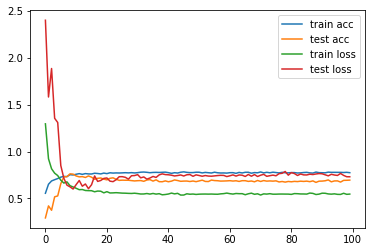

In [272]:
plt.plot(history.history['categorical_accuracy'], label = "train acc")
plt.plot(history.history['val_categorical_accuracy'], label = "test acc")
plt.plot(history.history['loss'], label = "train loss")
plt.plot(history.history['val_loss'], label = "test loss")

plt.legend()
plt.show()

In [126]:
model.evaluate_generator(test_generator)

[3.0392701625823975, 0.30890539288520813]

In [127]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, confusion_matrix

In [127]:
y_test = test_df.catg
X_test = np.array([np.load(path + file) for file in test_df.ID])
X_test = X_test.reshape((*X_test.shape, 1))
y_pred = model.predict(X_test)
y_pred.sum(axis=0)

array([1704.,   29.,    0.,    0.,   11.], dtype=float32)

In [73]:
tf.math.confusion_matrix(labels=y_test, predictions=y_pred.argsort()[:,-1])

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[  0, 523,  70,   0,   2],
       [  0, 355,  19,   0,   0],
       [  0, 118, 470,   0,   0],
       [  0, 207, 141,   0,   0],
       [  0, 312, 104,   0,   3]])>

In [59]:
test_df[test_df.catg==4]

,ID,catg
9512,c_4_Turdus-philomelos-1251201.npy,4
9513,c_4_Turdus-philomelos-12512010.npy,4
9514,c_4_Turdus-philomelos-12512011.npy,4
9515,c_4_Turdus-philomelos-12512012.npy,4
9525,c_4_Turdus-philomelos-12512021.npy,4
...,...,...
11600,c_4_Turdus-philomelos-53669061.npy,4
11602,c_4_Turdus-philomelos-53669063.npy,4
11603,c_4_Turdus-philomelos-5366907.npy,4
11604,c_4_Turdus-philomelos-5366908.npy,4


In [294]:
test_df.catg.value_counts()

0    595
2    588
3    419
1    374
Name: catg, dtype: int64

In [187]:
y_test = to_categorical(y_test, num_classes=len(y_test.unique()))
roc_auc_score(y_test, y_pred)

In [149]:
y_test = test_df.catg

In [150]:
y_pred.argsort()[:,-1]

array([3, 1, 3, ..., 3, 3, 3], dtype=int64)

In [8]:
label_to_name = data[['Name','class_label']].set_index('class_label').to_dict()['Name']

In [9]:
counting = pd.Series(y_train).map(label_to_name).value_counts()

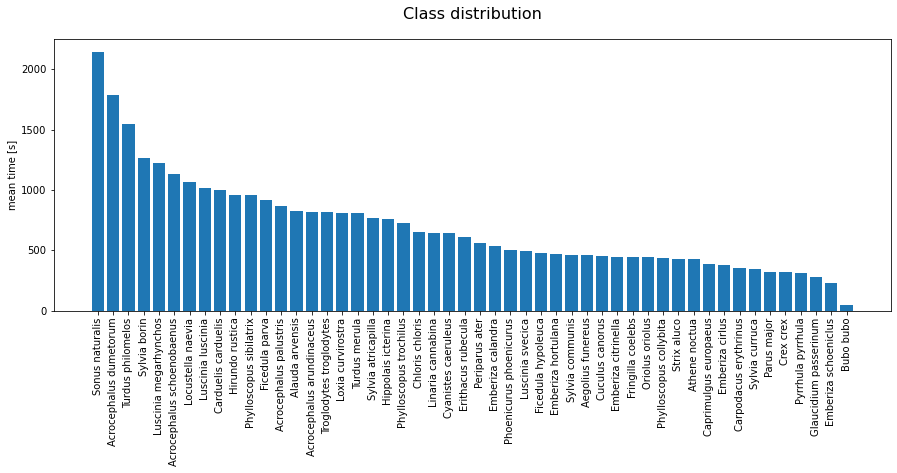

In [10]:
# plt.bar(pd.Series(y_train).map(label_to_name))
plt.figure(figsize=(15,5))
plt.bar(counting.index, counting.values)
plt.xticks(rotation = 90)
plt.xlabel(None)
plt.ylabel('mean time [s]')
plt.title('Class distribution', fontdict={'size':16}, y=1.05)
plt.show()

In [85]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=16, epochs=10, callbacks=[early_stopping, history])

Epoch 1/10
3282/3282 [==============================] - 57s 17ms/step - loss: 3.8326 - categorical_accuracy: 0.0696 - val_loss: 3.8960 - val_categorical_accuracy: 0.0667
Epoch 2/10
3282/3282 [==============================] - 55s 17ms/step - loss: 3.6079 - categorical_accuracy: 0.0981 - val_loss: 3.8217 - val_categorical_accuracy: 0.0972
Epoch 3/10
3282/3282 [==============================] - 55s 17ms/step - loss: 2.9747 - categorical_accuracy: 0.2385 - val_loss: 4.4870 - val_categorical_accuracy: 0.1478
Epoch 4/10
3282/3282 [==============================] - 55s 17ms/step - loss: 1.9638 - categorical_accuracy: 0.4663 - val_loss: 7.0424 - val_categorical_accuracy: 0.1270
Epoch 5/10
3282/3282 [==============================] - 55s 17ms/step - loss: 1.5593 - categorical_accuracy: 0.5665 - val_loss: 7.0091 - val_categorical_accuracy: 0.1128
Epoch 6/10
3282/3282 [==============================] - 54s 17ms/step - loss: 1.3282 - categorical_accuracy: 0.6256 - val_loss: 8.2526 - val_categoric

In [87]:
y_pred = model.predict_proba(X_test)

In [91]:
from sklearn.metrics import roc_auc_score

In [92]:
roc_auc_score(y_test, y_pred)

0.7729701757728127

In [108]:
'.'.join(['aafaf', '232'])

'aafaf.232'

In [59]:
ar_test = np.array([[1,3,4,4,5,2,6,62],[1,3,4,4,5,2,6,62]])

In [103]:
full_shape = (2,3,20)

In [105]:
len(full_shape)

3

In [107]:
np.zeros((full_shape[-1] - 8))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [93]:
slice(ar_test, 3)

slice(array([[ 1,  3,  4,  4,  5,  2,  6, 62],
       [ 1,  3,  4,  4,  5,  2,  6, 62]]), 3, None)

In [90]:
np.zeros((ar_test.shape[1]+4)).shape

(12,)

In [82]:
np.sum((ar_test, np.zeros((ar_test.shape[0], ar_test.shape[1]+4))), axis=1).shape

C:\Users\antos\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: could not broadcast input array from shape (2,8) into shape (2)

In [111]:
song2 = AudioSegment.from_mp3(r'./samples/signal/Acrocephalus-arundinaceus-178787.mp3')
samples2 = song2.get_array_of_samples()
samples2 = np.array(samples2, dtype=float)

In [129]:
# from scipy.signal.windows import hann
song = AudioSegment.from_mp3(r'./samples/signal/Sonus-naturalis-156938.mp3')
samples = song.get_array_of_samples()
samples = np.array(samples, dtype=float)

In [130]:
sr = 22050

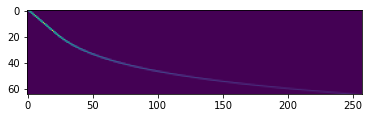

In [131]:
filter_banks = librosa.filters.mel(sr=sr, n_fft=512, n_mels=64)
filter_banks.shape
plt.imshow(filter_banks)
plt.show()

In [15]:
mel_spec = librosa.feature.melspectrogram(samples[:3*sr], sr=sr, n_fft=512, hop_length=int(512*.5), n_mels=64)
mel_spec2 = librosa.feature.melspectrogram(samples2[:3*sr], sr=sr, n_fft=512, hop_length=int(512*.5), n_mels=64)
mel_spec.shape

(64, 259)

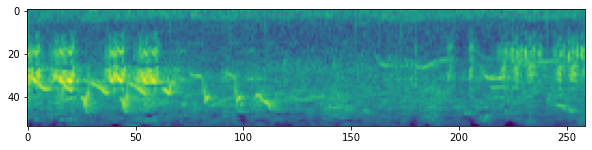

In [16]:
log_mel_spec = librosa.power_to_db(mel_spec+mel_spec2)
plt.figure(figsize=(10,5))
plt.imshow(log_mel_spec[5:-5])
plt.show()

In [17]:
np.save('./numpy_data/test.npy', log_mel_spec[5:-5])

In [18]:
'rr.wr'.split('.')

['rr', 'wr']

In [135]:
mfccs = librosa.feature.mfcc(samples[:3*sr], n_mfcc=13, sr=sr, hop_length=int(512), n_mels=128, n_fft=512)
mfccs.shape

(13, 130)

In [165]:
mfccs.shape[1]//130

2

In [166]:
import librosa.display

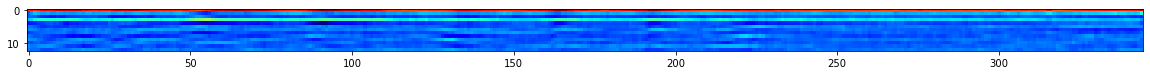

In [167]:
plt.figure(figsize=(20,10))
# librosa.display.specshow(mfccs,
#                         x_axis='time',
#                         sr=sr)
# plt.colorbar(format="%+2f")
plt.imshow(mfccs, cmap='jet')
plt.show()

In [168]:
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

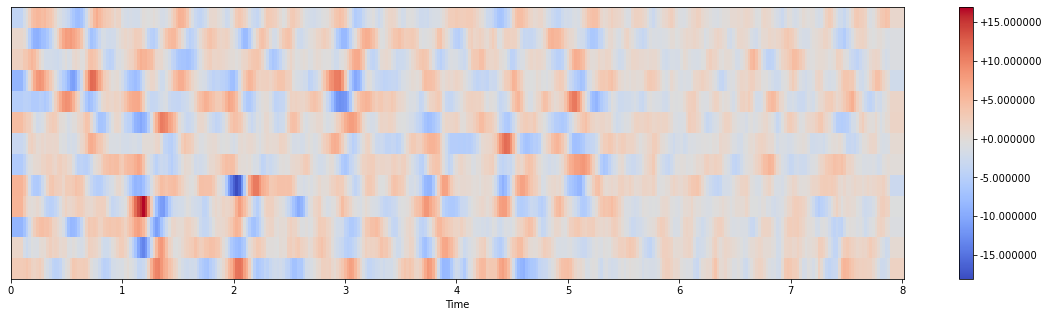

In [169]:
plt.figure(figsize=(20,5))
librosa.display.specshow(delta_mfccs,
                        x_axis='time',
                        sr=sr)
plt.colorbar(format="%+2f")
# plt.imshow(mfccs)
plt.show()

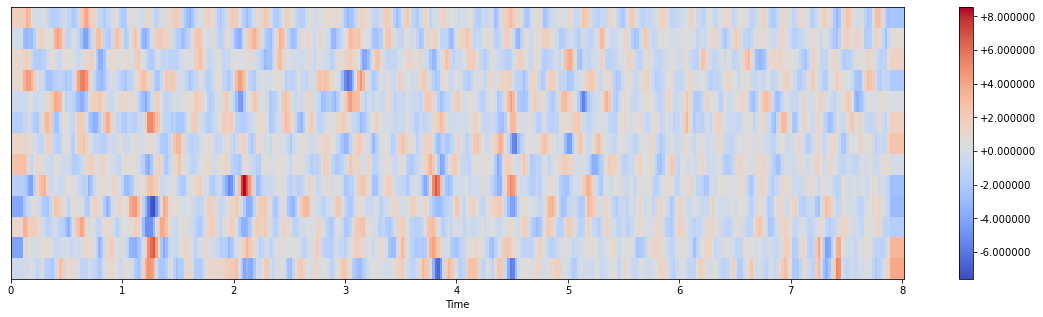

In [170]:
plt.figure(figsize=(20,5))
librosa.display.specshow(delta2_mfccs,
                        x_axis='time',
                        sr=sr)
plt.colorbar(format="%+2f")
# plt.imshow(mfccs)
plt.show()

In [171]:
comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
comprehensive_mfccs.shape

(39, 345)

In [172]:
comprehensive_mfccs[:,:1000].shape

(39, 345)

In [173]:
comprehensive_mfccs

array([[ 4.58779309e+02,  4.67405955e+02,  4.58564491e+02, ...,
         4.60810103e+02,  4.63070086e+02,  4.99240266e+02],
       [ 1.04579673e+00,  3.91033951e+01,  6.83595010e+01, ...,
         6.94740851e+01,  8.12091778e+01,  1.10621400e+02],
       [ 1.10375147e+00,  6.28851204e+00, -2.52211830e+00, ...,
        -4.26740408e+01, -3.25150880e+01, -4.72058679e+01],
       ...,
       [ 1.14295341e+00,  1.14295341e+00,  1.14295341e+00, ...,
         1.60682002e+00,  1.60682002e+00,  1.60682002e+00],
       [-3.21349969e-01, -3.21349969e-01, -3.21349969e-01, ...,
         7.81654344e-01,  7.81654344e-01,  7.81654344e-01],
       [ 1.77458146e+00,  1.77458146e+00,  1.77458146e+00, ...,
        -2.37135136e+00, -2.37135136e+00, -2.37135136e+00]])

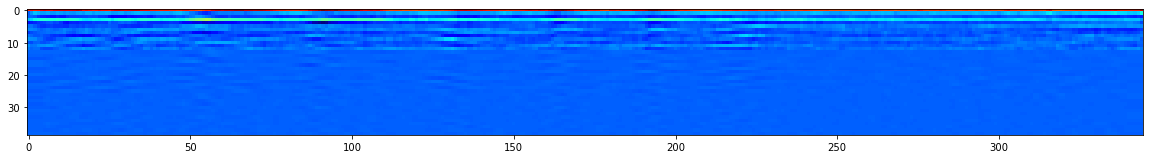

In [174]:
plt.figure(figsize=(20,5))
plt.imshow(comprehensive_mfccs, cmap='jet')
plt.show()

In [254]:
130/3

43.333333333333336

In [255]:
from scipy.signal import stft
window_size: int = 512
sr = 22050
bot_bins_out: int = 4
top_bins_out: int = 24
overlapping = .75

f, t, Zxx = stft(samples[:3*sr], nperseg=window_size, nfft=window_size, window='hann', noverlap=int(window_size * overlapping),
                     fs=sr)
Zxx = np.abs(Zxx)
Zxx = Zxx[bot_bins_out:-top_bins_out, :]
Zxx = np.log1p(Zxx)

(229, 518)


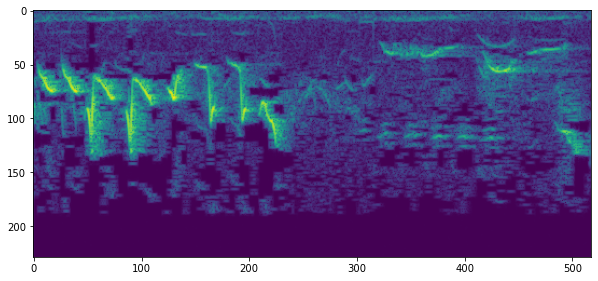

In [256]:
print(Zxx.shape)
plt.figure(figsize=(10,5))
plt.imshow(Zxx)
plt.show()

In [4]:
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tempfile import mktemp

In [26]:
song = AudioSegment.from_mp3(r'./test/Turdus-philomelos-240109.mp3')

In [24]:
song = AudioSegment.from_mp3(r'./test/Turdus-philomelos-240109.mp3')
samples = np.array(song.get_array_of_samples(), dtype=float).reshape(-1, song.channels)
# .reshape(-1, track.channels)

# samples = song.get_array_of_samples()
# samples = np.array(samples, dtype=float)

# signal, _ = librosa.load(r'./test/Turdus-philomelos-240109.mp3', sr=22050)

WINDOW_SIZE = 512
y = librosa.stft(samples, hop_length=512, n_fft = WINDOW_SIZE)

y = np.log1p(np.abs(y[:,:1000]))
print(y.shape)

plt.figure(figsize=(20,20))
plt.imshow(y)
plt.show()

ParameterError: Invalid shape for monophonic audio: ndim=2, shape=(2827055, 2)

In [3]:
data = pd.read_csv(r'metadata.csv')
data['Name'] = data.Genus +' '+ data.Specific_epithet

def timedeltas(x):
    t = datetime.strptime(x, '%M:%S').time()
    return timedelta(minutes=t.minute, seconds=t.second)

data['duration'] = data['Length'].apply(lambda x: timedeltas(x).total_seconds())

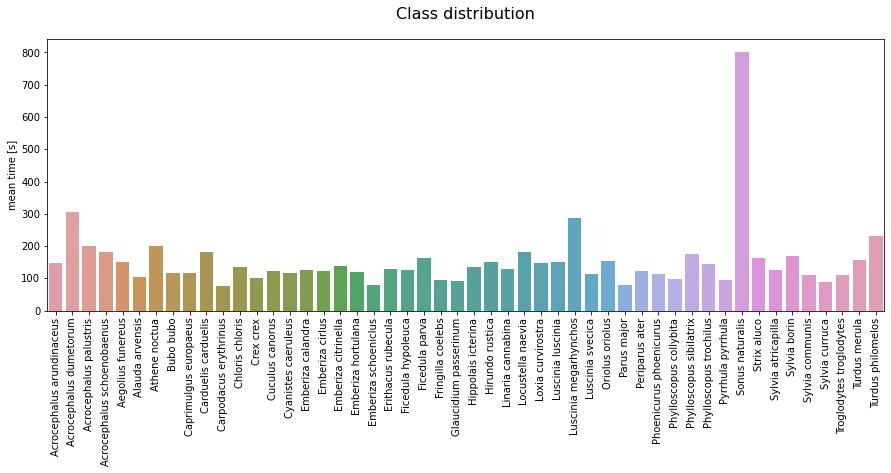

In [4]:
plotting = data.groupby(['Name'])['duration'].mean()
plt.figure(figsize=(15,5))
sns.barplot(x=plotting.index, y=plotting.values, saturation=0.6)
plt.xticks(rotation = 90)
plt.xlabel(None)
plt.ylabel('mean time [s]')
plt.title('Class distribution', fontdict={'size':16}, y=1.05)
plt.show()

In [29]:
# data[['sample_rate', 'num_samples']] = add_sample_info(data, 'Path', dur=False)

# with open('dataset.pkl', 'wb') as f:
#     pickle.dump(data, f)

with open('dataset.pkl', 'rb') as f:
    data = pickle.load(f)

classes = data.Name.unique()

signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes[0:4]:
    ix = data[data.Name == c].index[-1]
    f = data.loc[ix].Path
    fs = data.loc[ix].sample_rate
    signal, rate = librosa.load(f, sr=fs)
    signals[c] = signal
    fft[c] = fft_calc(signal, rate)

C:\Users\antos\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [30]:
sample_plot = ap.exploration.Visualize(signal=signals, fft=fft)

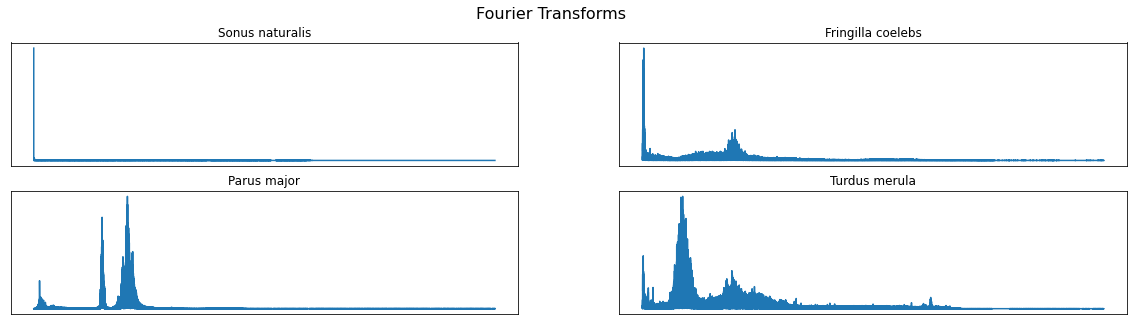

In [32]:
sample_plot.fft_plot()

In [241]:
from python_speech_features import mfcc, logfbank

In [249]:
# signals = {}
# fft = {}
# fbank = {}
# mfccs = {}

# for c in class_names:
#     mp3_file = data[data.Name == c].iloc[0,0]
#     song = AudioSegment.from_mp3(file)
#     fs = song.frame_rate
#     signal, _ = librosa.load(file, sr=fs)
#     signals[c] = signal
#     fft[c] = calc_fft(signal, fs)
    
#     bank = logfbank(signal[:fs], fs, nfilt=128, nfft=1200).T
#     fbank[c] = bank
#     mel = mfcc(signal[:fs], fs, numcep=64, nfilt=128, nfft=1200).T
#     mfccs[c] = mel

In [66]:
import os

In [46]:
from pydub import AudioSegment

In [61]:
song = AudioSegment.from_mp3(r'./Sonus-naturalis-156938.mp3')
samples = song.get_array_of_samples()
samples = np.array(samples, dtype=float)

In [62]:
samples = song.get_array_of_samples()

In [63]:
samples = np.array(samples, dtype=float)

C:\Users\antos\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


371 ms ± 6.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


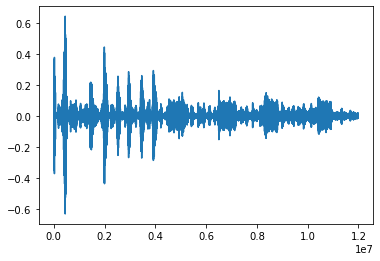

In [45]:
file = r'./Sonus-naturalis-156938.mp3'
song = AudioSegment.from_mp3(file)
fs = song.frame_rate

signal, _ = librosa.load(file, sr=fs)
plt.plot(signal)
plt.show()

In [259]:
import sox

In [260]:
cbn = sox.Transformer()
cbn.convert(samplerate=22050, n_channels=1)
cbn.build(
    input_filepath = './mp3/Sonus-naturalis-156938.mp3', output_filepath = 'Sonus-naturalis-156938.mp3'
)

True

In [261]:
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr=fs)
plt.show()

NameError: name 'signal' is not defined

<Figure size 1008x360 with 0 Axes>

In [92]:
# import IPython.display as ipd
# ipd.Audio(x, rate=fs)

(257, 500)


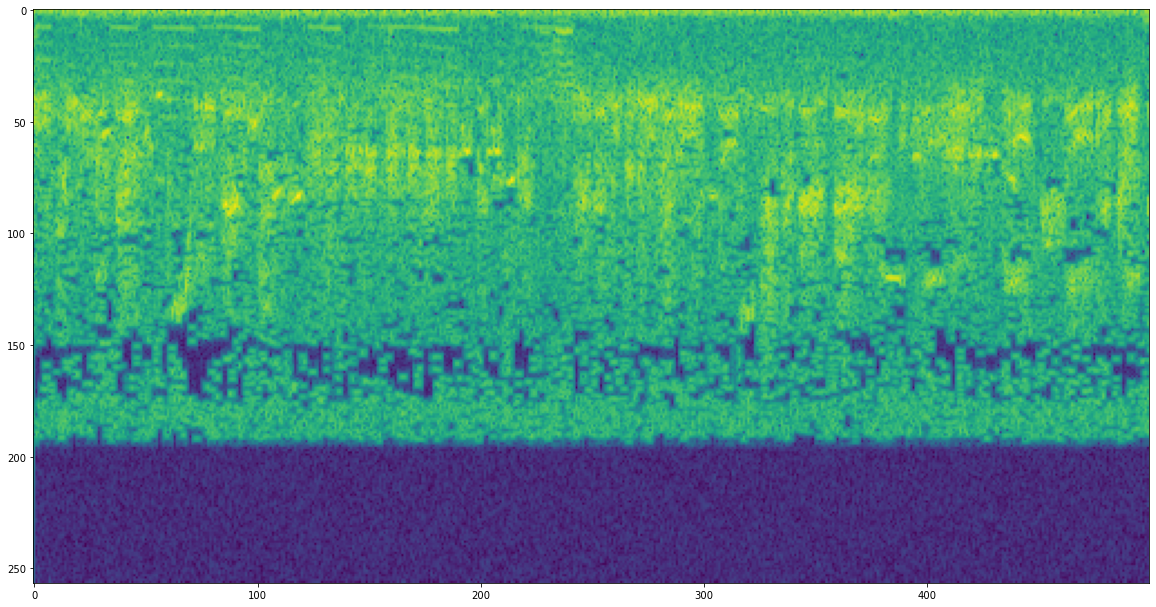

In [280]:
WINDOW_SIZE = 512
y = librosa.stft(samples, hop_length=256, n_fft = WINDOW_SIZE)#, hop_length = 512)
# y = librosa.feature.melspectrogram(x, sr=44100, n_fft=WINDOW_SIZE, hop_length=WINDOW_SIZE)

y = np.log1p(np.abs(y[:,:500]))
print(y.shape)

plt.figure(figsize=(20,20))
plt.imshow(y)
plt.show()

(257, 500)


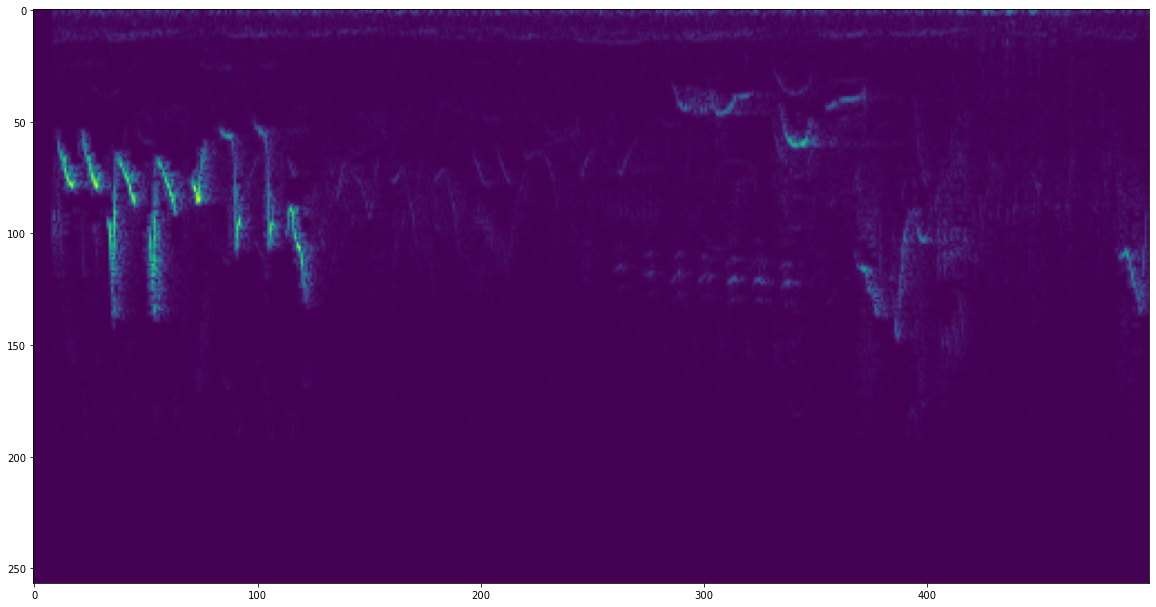

In [41]:
WINDOW_SIZE = 512
y = librosa.stft(signal, hop_length=256, n_fft = WINDOW_SIZE)#, hop_length = 512)
# y = librosa.feature.melspectrogram(x, sr=44100, n_fft=WINDOW_SIZE, hop_length=WINDOW_SIZE)

y = np.log1p(np.abs(y[:,:500]))
print(y.shape)

plt.figure(figsize=(20,20))
plt.imshow(y)
plt.show()